In [ ]:
%cd /content/drive/MyDrive/Hien
!ls

/content/drive/MyDrive/Hien
5.CNN_VuXuanHien	       ResNet50.pt	      test
dog-vs-cat-classification.zip  sample_submission.csv  train


In [ ]:
# !unzip dog-vs-cat-classification.zip 

In [ ]:
!ls

dog-vs-cat-classification.zip  sample_submission.csv  test  train  Untitled


# Ly thuyet

In [ ]:
'''
    1.D
    2.C
    3.C
    4.D
    5.C

'''

# câu 5 C

# Thuc Hanh

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.10.0+cu111


2 classes:
['cats', 'dogs']


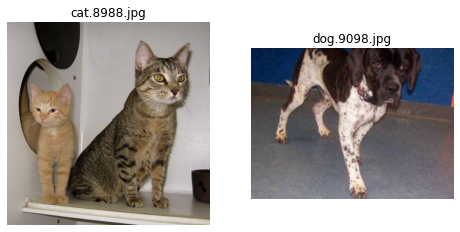

In [ ]:
# The images are in the data/shapes folder
data_path = 'train/train'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

In [ ]:
from torchvision.transforms.transforms import CenterCrop
# Load data

def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),

        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (80% and testing (20%) datasets)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256,
        num_workers=2,
        shuffle=True
    )
    

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=256,
        num_workers=2,
        shuffle=True
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


In [ ]:
class CatnDog(nn.Module):
    # Constructor
    def __init__(self, num_classes=2):
        super(CatnDog, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.drop = nn.Dropout2d(p=0.2)

        self.fc = nn.Linear(in_features=56 * 56 * 32, out_features=num_classes)

    def forward(self, x):

        x = F.relu(self.pool(self.conv1(x)))

        x = F.relu(self.pool(self.conv2(x)))
        
        x = F.relu(self.drop(self.conv3(x)))
        
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 56 * 56 * 32)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = CatnDog(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 15
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/20000 (0%)] Loss: 0.693751
Training set [2560/20000 (13%)] Loss: 0.692595
Training set [5120/20000 (25%)] Loss: 0.663515
Training set [7680/20000 (38%)] Loss: 0.678167
Training set [10240/20000 (51%)] Loss: 0.682559
Training set [12800/20000 (63%)] Loss: 0.668982
Training set [15360/20000 (76%)] Loss: 0.676526
Training set [17920/20000 (89%)] Loss: 0.676203
Training set: Average loss: 0.728207
Validation set: Average loss: 0.663397, Accuracy: 3012/5000 (60%)

Epoch: 2
Training set [0/20000 (0%)] Loss: 0.673800
Training set [2560/20000 (13%)] Loss: 0.651682
Training set [5120/20000 (25%)] Loss: 0.632659
Training set [7680/20000 (38%)] Loss: 0.615952
Training set [10240/20000 (51%)] Loss: 0.633771
Training set [12800/20000 (63%)] Loss: 0.642814
Training set [15360/20000 (76%)] Loss: 0.643575
Training set [17920/20000 (89%)] Loss: 0.613961
Training set: Average loss: 0.641763
Validation set: Average loss: 0.608602, Accuracy: 3330/5000 (67%)

Epoch

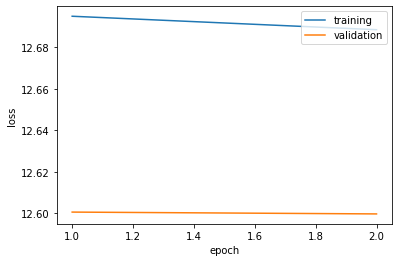

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


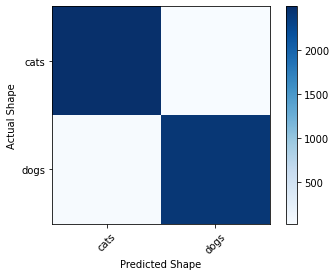

In [ ]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

# Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self, trial):
        # We optimize dropout rate in a convolutional neural network.
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=2)
        dropout_rate = trial.suggest_float("dropout_rate", 0, 1)
        self.conv2_drop = nn.Dropout2d(p=dropout_rate)
        fc2_input_dim = trial.suggest_int("fc2_input_dim", 40, 80)
        self.fc1 = nn.Linear(56 * 56 * 32, fc2_input_dim)
        self.fc2 = nn.Linear(fc2_input_dim, 2)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.drop(self.conv3(x)))

        x = x.view(-1, 56 * 56 * 32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
DEVICE = torch.device("cuda")
BATCHSIZE = 256
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 500
N_VALID_EXAMPLES = BATCHSIZE * 100

def objective(trial):

    # Generate the model.
    model = Net(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    loss_criteria = nn.CrossEntropyLoss()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_criteria(output, target.reshape(-1,1))
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = torch.tensor(output.data>=0.5).float()
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-26 17:03:43,335] A new study created in memory with name: no-name-d0f23b98-9bd4-471c-8378-eea106a62004
[W 2022-02-26 17:03:45,418] Trial 0 failed because of the following error: RuntimeError('Expected 4-dimensional input for 4-dimensional weight [32, 3, 2, 2], but got 2-dimensional input of size [256, 150528] instead')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-19-e9718a12a703>", line 30, in objective
    output = model(data)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-16-29103b7828e1>", line 16, in forward
    x = F.relu(self.pool(self.conv1(x)))
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib

RuntimeError: ignored

# Pretrain ResNet

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Set the existing feature extraction layers to read-only
for param in model.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Now print the full model, which will include the feature extraction layers of the base model and our prediction layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    
CUDA_LAUNCH_BLOCKING=1
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 20
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/20000 (0%)] Loss: 0.084335
Training set [2560/20000 (13%)] Loss: 0.033543
Training set [5120/20000 (25%)] Loss: 0.032676
Training set [7680/20000 (38%)] Loss: 0.027326
Training set [10240/20000 (51%)] Loss: 0.028938
Training set [12800/20000 (63%)] Loss: 0.045478
Training set [15360/20000 (76%)] Loss: 0.014889
Training set [17920/20000 (89%)] Loss: 0.045563
Training set: Average loss: 0.037959
Validation set: Average loss: 0.041946, Accuracy: 4922/5000 (98%)

Epoch: 2
Training set [0/20000 (0%)] Loss: 0.053447
Training set [2560/20000 (13%)] Loss: 0.017706
Training set [5120/20000 (25%)] Loss: 0.020647
Training set [7680/20000 (38%)] Loss: 0.030495
Training set [10240/20000 (51%)] Loss: 0.021103
Training set [12800/20000 (63%)] Loss: 0.039925
Training set [15360/20000 (76%)] Loss: 0.030745
Training set [17920/20000 (89%)] Loss: 0.016140
Training set: Average loss: 0.034107
Validation set: Average loss: 0.041306, Accuracy: 4924/5000 (98%)

Epoch

# Mobile Net

In [ ]:
model2 = torchvision.models.mobilenet_v2(pretrained=True)

print(model2)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
# Set the existing feature extraction layers to read-only
for param in model2.parameters():
    param.requires_grad = False

# Replace the prediction layer

model2.classifier[1] = nn.Linear(model2.last_channel, 2)

# Now print the full model, which will include the feature extraction layers of the base model and our prediction layer
print(model2)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
if torch.cuda.is_available():
    model2.cuda()

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()

        # loss.requires_grad = True
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on', device)

# Create an instance of the model class and allocate it to the device
model2 = model2.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 3 epochs (in a real scenario, you'd likely use many more)
epochs = 8
for epoch in range(1, epochs + 1):
        train_loss = train(model2, device, train_loader, optimizer, epoch)
        test_loss = test(model2, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/20000 (0%)] Loss: 0.627364
Training set [2560/20000 (13%)] Loss: 0.651688
Training set [5120/20000 (25%)] Loss: 0.664875
Training set [7680/20000 (38%)] Loss: 0.619971
Training set [10240/20000 (51%)] Loss: 0.631301
Training set [12800/20000 (63%)] Loss: 0.628709
Training set [15360/20000 (76%)] Loss: 0.643616
Training set [17920/20000 (89%)] Loss: 0.645789
Training set: Average loss: 0.642586
Validation set: Average loss: 0.634880, Accuracy: 3160/5000 (63%)

Epoch: 2
Training set [0/20000 (0%)] Loss: 0.608586
Training set [2560/20000 (13%)] Loss: 0.673836
Training set [5120/20000 (25%)] Loss: 0.633128
Training set [7680/20000 (38%)] Loss: 0.618358
Training set [10240/20000 (51%)] Loss: 0.651939
Training set [12800/20000 (63%)] Loss: 0.618731
Training set [15360/20000 (76%)] Loss: 0.659048
Training set [17920/20000 (89%)] Loss: 0.668562
Training set: Average loss: 0.642637
Validation set: Average loss: 0.634880, Accuracy: 3160/5000 (63%)

Epoch

# Data Augmentation

In [ ]:
from torchvision.transforms.transforms import CenterCrop
import albumentations 
# Load data

def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.5),
	      transforms.RandomRotation(45),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (80% and testing (20%) datasets)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256,
        num_workers=0,
        shuffle=False
    )
    

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=256,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()

        # loss.requires_grad = True
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 3 epochs (in a real scenario, you'd likely use many more)
epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/20000 (0%)] Loss: 0.660290
Training set [2560/20000 (13%)] Loss: 0.218865
Training set [5120/20000 (25%)] Loss: 0.139774
Training set [7680/20000 (38%)] Loss: 0.102878
Training set [10240/20000 (51%)] Loss: 0.092880
Training set [12800/20000 (63%)] Loss: 0.096406
Training set [15360/20000 (76%)] Loss: 0.090576
Training set [17920/20000 (89%)] Loss: 0.100092
Training set: Average loss: 0.157699
Validation set: Average loss: 0.086190, Accuracy: 4852/5000 (97%)

Epoch: 2
Training set [0/20000 (0%)] Loss: 0.069194
Training set [2560/20000 (13%)] Loss: 0.098010
Training set [5120/20000 (25%)] Loss: 0.083026
Training set [7680/20000 (38%)] Loss: 0.069927
Training set [10240/20000 (51%)] Loss: 0.068494
Training set [12800/20000 (63%)] Loss: 0.073128
Training set [15360/20000 (76%)] Loss: 0.077103
Training set [17920/20000 (89%)] Loss: 0.083479
Training set: Average loss: 0.082316
Validation set: Average loss: 0.072247, Accuracy: 4856/5000 (97%)

Epoch

KeyboardInterrupt: ignored

# Submission

In [ ]:
# Save the model weights
model_file = 'ResNet50.pt'
torch.save(model.state_dict(), model_file)

In [ ]:
model_save = torchvision.models.resnet50(pretrained=True)
# Set the existing feature extraction layers to read-only
for param in model_save.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = model_save.fc.in_features
model_save.fc = nn.Linear(num_ftrs, len(classes))

model_save.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

,id,labels
0,000000.jpg,1
1,000001.jpg,1
2,000002.jpg,1
3,000003.jpg,1
4,000004.jpg,1


In [ ]:
import pandas as pd

test_filenames = os.listdir("test/test")
test_df = pd.DataFrame({
    'id': test_filenames
})

In [ ]:
from PIL import Image
def predict_image(classifier, image_path):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path)
    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index

In [ ]:
labels = []
for image in test_df['id']:
  index = predict_image(model, 'test/test/' + str(image))
  labels.append(index)


In [ ]:
test_df['labels'] = labels
test_df = test_df.sort_values(by='id')
test_df.to_csv('sub.csv', index=False)

In [ ]:
test_df

,id,labels
7020,000000.jpg,1
7009,000001.jpg,1
7022,000002.jpg,1
7032,000003.jpg,0
7005,000004.jpg,1
...,...,...
809,007995.jpg,1
786,007996.jpg,0
994,007997.jpg,1
832,007998.jpg,1
